<a href="https://colab.research.google.com/github/tarishijain/Python/blob/master/Detectron2CatDataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detectron2**
---
Objective

*   Run inference on images or videos, with an existing detectron2 model
*   Train a detectron2 model on a new dataset




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [2]:
import json
import glob
import numpy as np

**Install detectron2**

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#Train on a custom dataset

---
In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

I have use the cat dataset which only has one class: cat. We'll train the model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.


#Prepare the dataset
---
Using labelme prepare the annotated data, then upload the zip file.


In [ ]:
!unzip Cats.zip

In [ ]:
#categories_dict = {"cat" : 0}

In [ ]:
labels = []
for i in img_json['shapes']:
    labels.append(i['label'])
categories_dict = {}
count = 0
for i in set(labels):
    categories_dict[i] = count
    count+=1
categories_dict     

In [ ]:
im = cv2.imread("/content/Cats/00000103_022.jpg")
cv2_imshow(im)

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

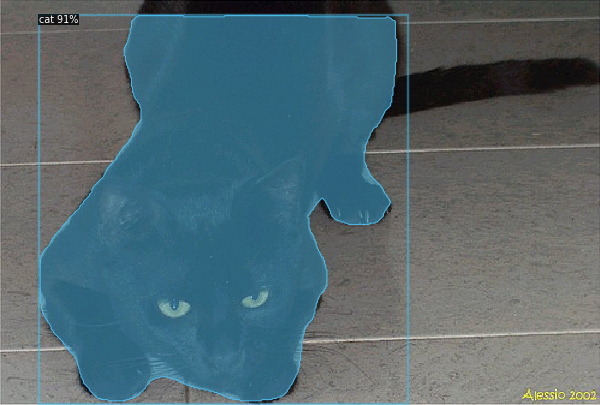

In [14]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

COCO dataset format for object detection
---
annotation{
"id": int, "image_id": int, "category_id": int, "segmentation": RLE or [polygon], "area": float, "bbox": [x,y,x,y], "iscrowd": 0 or 1,
}

categories[{
"id": int, "name": str, "supercategory": str,
}]

In [15]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")
from detectron2.structures import BoxMode

def get_custom_dicts(img_dir):
    os.chdir(img_dir)
    count = 1
    file_list= []
    for file in glob.glob("*.json"):  #extracting the names  of json files in file list.
        file_list.append(file)
    dataset_dicts = []
    for file in file_list:            #iterating over each json to extract the raw data.
        json_file_path = os.path.join(img_dir, file)
        with open(json_file_path) as f:
            img_json = json.load(f)

        # extracting the labels from the json file.
        labels = []
        for i in img_json['shapes']:
            labels.append(i['label'])
        categories_dict = {}
        count = 0
        for i in set(labels):
            categories_dict[i] = count
            count+=1    

        #preparing the COCO format for object detection..    https://cocodataset.org/#format-data
        record = {}
        path = img_json['imagePath']  
        path = path[14:]
        filename = os.path.join(img_dir,path )
        height, width = img_json['imageHeight'], img_json['imageWidth']
            
        record["file_name"] = filename
        record["image_id"] = count
        record["height"] = height
        record["width"] = width
        objs = []

        for i in range(len(img_json['shapes'])):
            points = img_json['shapes'][i]['points']
            mat = np.matrix(points)
            xmin,xmax,ymin,ymax = np.min(mat[:,0]), np.max(mat[:,0]), np.min(mat[:,1]), np.max(mat[:,1])
            poly = list(np.ravel(mat))
            obj = {
                "bbox": [xmin,ymin,xmax,ymax], 
                "bbox_mode": BoxMode.XYXY_ABS, #BoxMode.XYWH_ABS
                "segmentation": [poly], #list of list
                "category_id": categories_dict[img_json['shapes'][i]['label']],
            }
            objs.append(obj)
        record["annotations"] = objs  #list of dictionary
        dataset_dicts.append(record)
        count+=1

    return dataset_dicts

In [ ]:
d = 0
DatasetCatalog.register("cat", lambda d=d: get_custom_dicts("/content/Cats")) 
MetadataCatalog.get("cat").set(thing_classes=["cat"])
cats_metadata = MetadataCatalog.get("cat")

In [30]:
dataset_dicts = get_custom_dicts("/content/Cats")

In [18]:
print(dataset_dicts)

[{'file_name': '/content/Cats/00000100_027.jpg', 'image_id': 1, 'height': 407, 'width': 500, 'annotations': [{'bbox': [108.43103448275863, 39.224137931034484, 440.75862068965523, 406.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[151.1034482758621, 63.362068965517246, 143.34482758620692, 109.05172413793105, 145.93103448275863, 118.96551724137932, 127.82758620689657, 146.1206896551724, 116.62068965517244, 168.5344827586207, 108.43103448275863, 200.0, 108.43103448275863, 237.50000000000003, 115.75862068965517, 286.6379310344828, 127.82758620689657, 301.7241379310345, 125.24137931034485, 334.9137931034483, 138.6034482758621, 360.7758620689655, 141.1896551724138, 378.01724137931035, 141.62068965517244, 397.8448275862069, 154.98275862068968, 401.2931034482759, 164.4655172413793, 403.448275862069, 280.0, 406.0, 354.0, 406.0, 360.15517241379314, 396.12068965517244, 376.5344827586207, 400.0, 394.6379310344828, 400.86206896551727, 403.68965517241384, 389.22413793103453, 407.137931034

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cats_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# check more config on https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md or github: https://github.com/facebookresearch/detectron2/blob/main/detectron2/model_zoo/model_zoo.py
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cat",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [40]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cats_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_custom_dicts("/content/Cats")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=cats_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("cat", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "cat")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [ ]:
# Inference with a miscellaneous model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])   

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])